We group the left and right answers. To do that, we take |Y| instead of Y, and we take a likelihood of response $p(\text{resp} = 1) = p(\text{resp} = \text{left}) + p(\text{resp} = \text{right}) = \sigma(X,\beta,bias) + \sigma(-X,\beta,bias)$
where $\sigma(x) = \frac{1}{1+\exp(-\beta X)}$ is the logistic function.

(actually it is probably the wrong likelihood: instead it could be 
$p(\text{resp} = 1) = \cfrac{\exp (-\beta_{\text{left}} X) + \exp (-\beta_{\text{right}} X)}{\exp (-\beta_{\text{left}} X) + \exp (-\beta_{\text{right}} X) + \exp (-\beta_{\text{noresp}} X)}$: see manuscript notes)

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat #alternative: mat2py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import scipy
import sys
path_data = '../data_BAMB/behaviour_EEG_syn/'



def distri_sumsigmoids(x,beta,bias):
    return sigmoid(x, beta, bias) + sigmoid(-x, beta, bias)

def sigmoid(x, beta, bias):
    return 1/(1+np.exp(- np.dot(x,beta) - bias))

# Negative LogLikelihood to be minimized. The binomial term has been discarded.
def llh_psycho_fit(weights,x,y):
#     print("x.shape,y.shape", x.shape,y.shape)
    p_1 = distri_sumsigmoids(x, weights[1:], weights[0]) #the bias needs to be negative as we want this quantity to be <1
#     print("p_1",p_1)
#     llh2=y*np.log(p_1)
#     llh3=(1-y)*np.log(1-p_1)
#     return -np.mean(llh2+llh3)
    return np.mean(y*np.log(p_1) + (1-y)*np.log(1-p_1))

def fun_to_minimize(weights):
#     llh = llh_psycho_fit(weights, X, y)
#     print("llh", llh, "likelihood:",np.exp(llh), "bias", weights[0], "weight_0", weights[1])
#     return -llh
    return -llh_psycho_fit(weights, X, y)

def jac_fun_to_minimize(weights): #see http://www.win-vector.com/blog/2011/09/the-simpler-derivation-of-logistic-regression/
    beta = weights[1:]
    bias = weights[0]
    sig_plus = sigmoid(X, beta, bias)
    sig_minus = sigmoid(-X, beta, bias)
    grad_sig_plus = sig_plus*(1-sig_plus)
    grad_sig_minus = sig_minus*(1-sig_minus)
#     print("grad_sig_plus.shape", grad_sig_plus.shape)
    
    A_y = (y/(sig_plus+sig_minus) - (1-y)/(1-sig_plus-sig_minus))
#     print("A_y.shape", A_y.shape)
    B_x_beta = X.T * (grad_sig_plus - grad_sig_minus)
#     print("B_x_beta.shape", B_x_beta.shape)
    B_x_bias = grad_sig_plus + grad_sig_minus
#     print("B_x_bias.shape", B_x_bias.shape)
    B_x = np.row_stack((B_x_beta, B_x_bias)) #or column_stack
#     print("B_x.shape",B_x.shape)
    grad_likelihood = np.dot(B_x,A_y)
#     print("grad_likelihood.shape", grad_likelihood.shape)
    return - grad_likelihood




In [56]:
#load the data for the fitting (one subject only)

subjects = [16]#,18,19,20,21,24,26,28,32,34,35,40,41,51,52] #there are 15 subjects
sessions = [1,2,3,4,5,6] #6 sessions by subject (with 4 conditions each)

nsubjects = len(subjects) #15
nsessions = len(sessions) #6
nconditions = 4 #number of conditions

last_dim_truncate = 29490 #minimum (on all the subjects and sessions) of the number of time bins in a {session,condition]
nframes = 500 #number of frames taken (to go back in time)

X_all = np.zeros((last_dim_truncate, nframes, nconditions, nsubjects, nsessions)) #too big
print(X_all.shape)
weights_fitted_subjects = []
for subject in subjects:
    print("subject",subject)
    
    X_all_cond_dict = {1:[], 2:[], 3:[], 4:[]}
    resp_all_cond_dict = {1:[], 2:[], 3:[], 4:[]}
    
    for sess in sessions:
        mat = loadmat(str(path_data) + '/sub' + str(subject).zfill(3) + '_sess' + str(sess).zfill(3) +\
                       '_behav_syn.mat')
        list_cond = [int(el[0]) for el in mat['S_behav'][0,0][0][0,:]]
        
        trigger_vals = mat['B'][0,0][12][0,:]
        trigger_vals = np.array([el[:,0] for el in trigger_vals])

        coherence_frame = mat['B'][0,0][14][0,:]
        coherence_frame = np.array([el[:,0] for el in coherence_frame])

        resp = np.zeros((4,trigger_vals.shape[1]))
        for cond in range(4):
            for trigger_value_left in [205,206]:
#                 resp[cond,trigger_vals[cond,:] == trigger_value_left] = -1 #3 labels (-1/0/1)
                resp[cond,trigger_vals[cond,:] == trigger_value_left] = 1 #2 labels (-0/1)
            for trigger_value_right in [201,202]:
                resp[cond,trigger_vals[cond,:] == trigger_value_right] = 1


        for i_cond, cond in enumerate(list_cond):
            resp_all_cond_dict[cond].append(resp[i_cond,:500+last_dim_truncate])
        
        X_all_cond = []
        for cond in range(4):
            X = []
            for i in range(nframes):
                beginning = 500-i
                end = coherence_frame.shape[1] - i
                X.append(coherence_frame[cond,beginning:end])
            X = np.array(X)
            X_all_cond.append(X)
        X_all_cond = np.array(X_all_cond)
        
        #truncate and put into dict (with the condition info)
        for i_cond, cond in enumerate(list_cond):
            X_all_cond_dict[cond].append(X_all_cond[i_cond,:,:last_dim_truncate])
        
    for cond in X_all_cond_dict.keys():
        X_all_cond_dict[cond] = np.concatenate((np.array(X_all_cond_dict[cond])),axis=1)
        
    for cond in resp_all_cond_dict.keys():
        resp_all_cond_dict[cond] = np.concatenate(np.array(resp_all_cond_dict[cond])[:,nframes:])

    weights_fitted = []
    for cond in range(1,5):
        print("   condition",cond)
        X = X_all_cond_dict[cond].T
        y = resp_all_cond_dict[cond]
        print("X.shape,y.shape", X.shape,y.shape)

#         ############## GLM (slow) ##########################
#         m = sm.GLM(y,X,family=sm.families.Binomial())
#         results = m.fit()
#         weights = results.params
#         print("weights.shape",weights.shape)
        
        ############## Logistic Regression (which we used in the summer school) ##########################
#         clf = LogisticRegression(penalty='l2', solver='lbfgs',
#                              multi_class='auto').fit(X, y)
#         clf = LogisticRegression(penalty='l1', solver='saga',
#                              multi_class='multinomial').fit(X, y)
#         weights = clf.coef_
        
        ##############  Modified Logistic Regression ##########################
#         print("X.shape", X_no_bias.shape)
#         X = np.concatenate((np.ones((X_no_bias.shape[0],1)), X_no_bias),axis=1) #adding constant for X (bias)
        print("X.shape", X.shape)
        #give initial value to the weights
        weights_0 = np.random.uniform(size=X.shape[1]+1) / X.shape[1] #random positive weights
#         weights_0 = 0.1*np.exp(-2*np.linspace(0,1,X.shape[1]+1)) #already give a decreasing shape
#         print(weights_0)
        weights_0[0] = -10 #bias (needs to be negative)
#         print("Initial value and gradient of the likelihood:")
#         print(fun_to_minimize(weights_0))
#         print(jac_fun_to_minimize(weights_0))
        #Run the optimization
#         res = scipy.optimize.minimize(fun_to_minimize, weights_0)
        res = scipy.optimize.minimize(fun_to_minimize, x0=weights_0, method='CG', jac=jac_fun_to_minimize, options={'disp':True}) #options={'maxiter':500}
        weights = res.x
#         print(bias, beta)
        print(weights.shape)
        sys.exit() #stops the program (to run the optimization on 1 subject only)

        weights_fitted.append(weights)
    weights_fitted = np.array(weights_fitted)
#     print(weights_fitted.shape)
    weights_fitted_subjects.append(weights_fitted)

weights_fitted_subjects = np.array(weights_fitted_subjects)
# print(weights_fitted_subjects.shape)

(29490, 500, 4, 1, 6)
subject 16
   condition 1
X.shape,y.shape (176940, 500) (176940,)
X.shape (176940, 500)
Initial value and gradient of the likelihood:
llh -0.01339232584359905 likelihood: 0.9866969523601606 bias -10.0 weight_0 0.0007197438309564994
-0.9866969523601606
llh -0.01339232584359905 likelihood: 0.9866969523601606 bias -10.0 weight_0 0.0007197438309564994
llh -0.013233004654365865 likelihood: 0.986854166615472 bias -10.0 weight_0 0.0007197438309564994
llh -0.013347391994387735 likelihood: 0.9867412894483458 bias -10.0 weight_0 0.0007197438309564994
llh -0.013379936144984995 likelihood: 0.9867091773137554 bias -10.0 weight_0 0.0007197438309564994
llh -0.013388763657318295 likelihood: 0.9867004671647678 bias -10.0 weight_0 0.0007197438309564994
llh -0.01339121108192207 likelihood: 0.986698052292723 bias -10.0 weight_0 0.0007197438309564994
llh -0.013391935640883128 likelihood: 0.9866973373720663 bias -10.0 weight_0 0.0007197438309564994
llh -0.01339217258366567 likelihood: 

NameError: name 'sys' is not defined

The minimization with scipy.optimize.minimize is too slow if we do not indicate the gradient. If we indicate the gradient, then it does not manage to find an appropriate step (for the gradient descent): "Warning: Desired error not necessarily achieved due to precision loss.". This is due to the function itself; I tried several optimization methods (method='CG', method='BFGS', ...etc) but I get the same warning every time.

In [24]:
#comparing the initial weights to the fitted weights
np.max(np.abs(weights[0] - weights_0[0])), np.max(np.abs(weights[1:] - weights_0[1:]))

(0.0, 0.0)

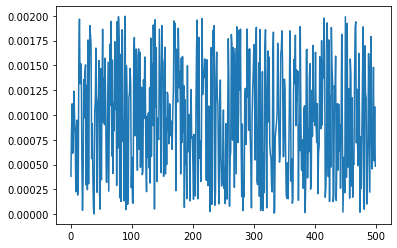

In [48]:
#plotting the weights (without the bias term)
plt.plot(weights[1:])
plt.xlabel('optimization iteration')
plt.show()

#plotting the smoothed weights (without the bias term)
def moving_average(x, w): #in order to smooth the curve of the weights
    return np.convolve(x, np.ones(w), 'valid') / w
mov_average_value = 10
plt.plot(moving_average(weights[1:], mov_average_value))
plt.show()